In [1]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from copulae1 import *
from KDEs import *
from toolbox import *
import warnings
import itertools
import os
warnings.filterwarnings("ignore")

data = pd.read_csv('../processed_data/btc_future_crix.csv')
data.head()

ecdf_brr = ECDF(data.return_brr)
ecdf_btc = ECDF(data.return_btc)

u = ecdf_brr(data.return_brr)
v = ecdf_btc(data.return_btc)

brr = np.array(data.return_brr)
btc = np.array(data.return_btc)

kde_brr = KDE(data.return_brr, "Gaussian")
kde_btc = KDE(data.return_btc, "Gaussian")

kde_brr = KDE(data.return_brr, "Gaussian", kde_brr.h_brot*3)
kde_btc = KDE(data.return_brr, "Gaussian", kde_btc.h_brot*3)

In [2]:
# Gaussian, t_Copula, Clayton, Frank, Gumbel, Plackett, Gaussian mix Indep
C1  = Gaussian(dict(rho=0.9),       Law_RS=kde_brr, Law_RF=kde_btc) # fix the maringals!
C2  = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=2) 
C2c = t_Copula(dict(rho=0.1, nu=4), Law_RS=kde_brr, Law_RF=kde_btc, nu_lowerbound=4) 
C3  = Clayton(dict(theta=0.1),      Law_RS=kde_brr, Law_RF=kde_btc)
C4  = Frank(dict(theta=0.1),        Law_RS=kde_brr, Law_RF=kde_btc)
C5  = Gumbel(dict(theta=3),         Law_RS=kde_brr, Law_RF=kde_btc)
C6  = Plackett(dict(theta=10),      Law_RS=kde_brr, Law_RF=kde_btc)
C7  = Gaussian_Mix_Independent(dict(rho=.5,p=0.7),Law_RS=kde_brr, Law_RF=kde_btc)
Copulae_names = ['Gaussian', 't_Copula', 't_Copula_Capped', 'Clayton', 'Frank', 'Gumbel', 'Plackett', 'Gauss Mix Indep']
Copulae_arr   = [C1,C2,C2c,C3,C4,C5,C6,C7]
Copulae = dict(zip(Copulae_names, Copulae_arr))


In [3]:
data_name = "future_brr_v5"
data_path = "../processed_data/"+data_name+"/"

# Risk Measures
# Variance is automatically included
k_arr = [10,20] # Absolute risk aversion for exponential risk measure
q_arr_ES = [0.01,0.05,0.1] # Quantile level for expected shortfall

spot_name = "log return brr"
future_name = "log return future"

paras_results = []
likelihood_results = []
best_h_results = []

calibration_method = "MM" # MM or MLE
q_arr = [0.05,0.1,0.9,0.95]

ls = os.listdir(data_path+'train/')
ls = [l for l in ls if l.endswith('.csv')]
for file in ls:
    # Calibration 
    train = pd.read_csv(data_path+'train/'+file)
    spot   = train.loc[:,spot_name]
    future = train.loc[:,future_name]
    u = ECDF(spot)(spot)
    v = ECDF(future)(future)
    
    kde_brr = KDE(spot, "Gaussian")
    kde_btc = KDE(future, "Gaussian")
    
    for C_name in Copulae:
        Copulae[C_name].Law_RS = kde_brr
        Copulae[C_name].Law_RF = kde_btc
    
    paras = []
    likelihood = []
    best_h = []
    for C_name in Copulae:
        if calibration_method == "MLE":
            Copulae[C_name].canonical_calibrate(u,v)
            
        elif calibration_method == "MM":
            Copulae[C_name].mm_calibrate(u,v,q_arr)

        print(C_name,'is done.\n')
    
    for C_name in Copulae:
        paras.append((C_name,Copulae[C_name].paras))
        
    for C_name in Copulae:
        ln = Copulae[C_name].dependency_likelihood(u,v)
        likelihood.append((C_name,ln))
        
    paras_results.append(paras)
    likelihood_results.append(likelihood)
    
    # Get Best h
    best_h = []
    for C_name in Copulae:
        best_h.append(optimize_h(Copulae[C_name], k_arr, q_arr_ES))
    best_h = pd.DataFrame(best_h)
    best_h.columns = ['Var'] + ['ERM k=%i'%k for k in k_arr] +  ['ES q=%.2f'%q for q in q_arr_ES]
    best_h.index = Copulae_names 
    best_h_results.append(best_h)
    
#     # Testing
#     test = pd.read_csv(data_path+'test/'+file)
#     spot_test   = train.loc[:,spot_name]
#     future_test = train.loc[:,future_name]

Optimization terminated successfully.
         Current function value: 0.020435
         Iterations: 32
         Function evaluations: 67
Gaussian is done.

Optimization terminated successfully.
         Current function value: 0.003632
         Iterations: 183
         Function evaluations: 348
t_Copula is done.

Optimization terminated successfully.
         Current function value: 0.009295
         Iterations: 200
         Function evaluations: 392
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: 0.309997
         Iterations: 46
         Function evaluations: 101
Clayton is done.

Optimization terminated successfully.
         Current function value: 0.109117
         Iterations: 51
         Function evaluations: 115
Frank is done.

Optimization terminated successfully.
         Current function value: 0.093042
         Iterations: 33
         Function evaluations: 72
Gumbel is done.

Optimization terminated successfully.
         Curr

Optimization terminated successfully.
         Current function value: 0.011036
         Iterations: 100
         Function evaluations: 206
t_Copula_Capped is done.

Optimization terminated successfully.
         Current function value: 0.370263
         Iterations: 41
         Function evaluations: 88
Clayton is done.

Optimization terminated successfully.
         Current function value: 0.060028
         Iterations: 40
         Function evaluations: 92
Frank is done.

Optimization terminated successfully.
         Current function value: 0.056378
         Iterations: 38
         Function evaluations: 81
Gumbel is done.

Optimization terminated successfully.
         Current function value: 0.022018
         Iterations: 43
         Function evaluations: 97
Plackett is done.

Optimization terminated successfully.
         Current function value: 0.010316
         Iterations: 70
         Function evaluations: 149
Gauss Mix Indep is done.

Optimization terminated successfully.
         

Optimization terminated successfully.
         Current function value: 0.044333
         Iterations: 41
         Function evaluations: 93
Plackett is done.

Optimization terminated successfully.
         Current function value: 0.004194
         Iterations: 77
         Function evaluations: 157
Gauss Mix Indep is done.

Optimization terminated successfully.
         Current function value: 0.000531
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.035579
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.047236
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.009736
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.001325
         Iterations: 16
         Function eval

Optimization terminated successfully.
         Current function value: 0.000505
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.034722
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.046161
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.009382
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.001228
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: -0.000067
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000695
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.008241
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000464
         Iterations: 15
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: -0.001494
         Iterations: 18
         Function evaluations: 39
Optimization terminated successfully.
         Current function value: 0.000653
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.036930
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.051637
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.009006
         Iterations: 16
         Function evaluations: 35
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.000714
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.040183
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.055557
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.010349
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.001919
         Iterations: 14
         Function evaluations: 29
Optimization terminated successfully.
         Current function value: -0.000072
         Iterations: 17
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 0.000593
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfu

Optimization terminated successfully.
         Current function value: 0.009841
         Iterations: 13
         Function evaluations: 27
Optimization terminated successfully.
         Current function value: 0.001794
         Iterations: 15
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.000065
         Iterations: 15
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 0.000566
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.036491
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.049428
         Iterations: 13
         Function evaluations: 26
Optimization terminated successfully.
         Current function value: 0.009554
         Iterations: 14
         Function evaluations: 30
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.000578
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.036912
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.049945
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.009686
         Iterations: 14
         Function evaluations: 31
Optimization terminated successfully.
         Current function value: 0.001638
         Iterations: 14
         Function evaluations: 30
Optimization terminated successfully.
         Current function value: 0.000096
         Iterations: 16
         Function evaluations: 33
Optimization terminated successfully.
         Current function value: 0.000470
         Iterations: 14
         Function evaluations: 28
Optimization terminated successful

In [4]:
c_arr = []
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)
    
    c = pd.DataFrame(paras_results[i])
    c.index = c.iloc[:,0]
    c = pd.DataFrame(c.iloc[:,1])
#     c.columns = ['paras']
    c_arr.append(c)
    
paras_results_pd = pd.concat(dict(zip(ls, c_arr)), axis=1)
paras_results_pd.columns = paras_results_pd.columns.droplevel(1)
paras_results_pd.index.name= None

l_arr = []
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)
    
    c = pd.DataFrame(likelihood_results[i])
    c.index = c.iloc[:,0]
    c = pd.DataFrame(c.iloc[:,1])
#     c.columns = ['likelihood']
    l_arr.append(c)
    
likelihood_results_pd = pd.concat(dict(zip(ls, l_arr)), axis=1)
likelihood_results_pd.columns = likelihood_results_pd.columns.droplevel(1)
likelihood_results_pd.index.name= None

In [5]:
paras_results_pd

,0.csv,1.csv,2.csv,3.csv,4.csv,5.csv,6.csv,7.csv
Gaussian,{'rho': 0.868553447466594},{'rho': 0.8642224865954938},{'rho': 0.8612872147644192},{'rho': 0.8703117617819549},{'rho': 0.8730188262923886},{'rho': 0.8692127849435228},{'rho': 0.8666918490082025},{'rho': 0.8081338451756866}
t_Copula,"{'rho': 0.7984046178459924, 'nu': 2.0000000000...","{'rho': 0.7926113769582546, 'nu': 2.0000000000...","{'rho': 0.7882896762434379, 'nu': 2.0000000000...","{'rho': 0.8006909401405042, 'nu': 2.0000000000...","{'rho': 0.8056842449009326, 'nu': 2.0000000000...","{'rho': 0.7997199035643903, 'nu': 2.0000000000...","{'rho': 0.7961101412675828, 'nu': 2.0000000000...","{'rho': 0.7839945363945668, 'nu': 7.6135356189..."
t_Copula_Capped,"{'rho': 0.8332042258538331, 'nu': 4.0000000000...","{'rho': 0.8280905804028438, 'nu': 4.0000000000...","{'rho': 0.8244215636145273, 'nu': 4.0000000000...","{'rho': 0.8352484316060429, 'nu': 4.0000000000...","{'rho': 0.8391311610624665, 'nu': 4.0000000000...","{'rho': 0.8342232707122057, 'nu': 4.0000000000...","{'rho': 0.8311167288138506, 'nu': 4.0000000000...","{'rho': 0.7839945276592335, 'nu': 7.6135320779..."
Clayton,{'theta': 10.947847784391264},{'theta': 9.154470041181986},{'theta': 8.088062072741808},{'theta': 9.004177371588227},{'theta': 9.013749959882473},{'theta': 8.922155352059782},{'theta': 8.685726470351252},{'theta': 2.0454614788206085}
Frank,{'theta': 20.003265931821314},{'theta': 19.430597816161356},{'theta': 19.028577299204635},{'theta': 20.307726061069285},{'theta': 20.70343149596748},{'theta': 20.174863262614835},{'theta': 19.79499999865897},{'theta': 13.96590162768224}
Gumbel,{'theta': 3.010422420415354},{'theta': 2.974684139802878},{'theta': 2.9404208895686326},{'theta': 3.0866100255989384},{'theta': 3.1608063645451425},{'theta': 3.0715529843258706},{'theta': 3.0279259420931335},{'theta': 2.4049179895643067}
Plackett,{'theta': 55.86483050994072},{'theta': 53.033409458911734},{'theta': 51.193637187565265},{'theta': 56.97697005068869},{'theta': 58.376117380002015},{'theta': 56.066433301085766},{'theta': 54.436553955078125},{'theta': 30.706293475135396}
Gauss Mix Indep,"{'rho': 0.9754684756914533, 'p': 0.74536018103...","{'rho': 0.9736026875096224, 'p': 0.74302091082...","{'rho': 0.9733856931471816, 'p': 0.73773172603...","{'rho': 0.9815486224122039, 'p': 0.72962236199...","{'rho': 0.9784085664435416, 'p': 0.74441338704...","{'rho': 0.9799308563843114, 'p': 0.73309664787...","{'rho': 0.9774855503750262, 'p': 0.73587516028...","{'rho': 0.890097492327843, 'p': 0.825364003271..."


In [6]:
likelihood_results_pd

,0.csv,1.csv,2.csv,3.csv,4.csv,5.csv,6.csv,7.csv
Gaussian,0.333659,0.318746,0.316669,0.292167,0.296233,0.299190,0.312008,0.379527
t_Copula,0.512646,0.502554,0.508860,0.508998,0.514303,0.508120,0.512276,0.444433
t_Copula_Capped,0.496810,0.485695,0.488947,0.486730,0.492198,0.484316,0.489160,0.444433
Clayton,-1.776669,-1.192184,-0.843170,-1.083443,-1.009371,-0.997692,-0.928517,0.348912
Frank,-0.256949,-0.233314,-0.189675,-0.304151,-0.307192,-0.313571,-0.269057,0.137283
Gumbel,0.407939,0.386135,0.389206,0.363522,0.352107,0.355794,0.370738,0.417044
Plackett,0.399286,0.400094,0.422289,0.403774,0.412298,0.401329,0.412351,0.443913
Gauss Mix Indep,0.381926,0.395543,0.425962,0.360551,0.391789,0.380483,0.409099,0.465790


In [7]:
best_h_results_pd = pd.concat(dict(zip(ls, best_h_results)), axis=1)

In [8]:
def cap(h):
    if h < 0:
        return 0
    elif h >1:
        return 1
    else:
        return h

In [9]:
columns = best_h_results_pd.columns
for c in columns:
     best_h_results_pd.loc[:,c] = best_h_results_pd.loc[:,c].apply(cap)

In [10]:
def hedging_effectiveness(h_arr, spot, future, k_arr, q_arr):
    results = np.ones((len(h_arr),1+len(k_arr)+len(q_arr)))
    for i, h in enumerate(h_arr):
        rh = spot-h*future
        results[i,:]=1-risk_measures(k_arr, q_arr, rh)/risk_measures(k_arr, q_arr, spot)
    return np.array([results[i,i] for i in range(len(h_arr))])

In [11]:
date_range_arr = []
for i, file in enumerate(ls):
    train = pd.read_csv(data_path+'train/'+file)
    date_range = train.Date.iloc[-1] +' to ' + train.Date.iloc[0]
    date_range_arr.append(date_range)

In [12]:
display_likelihood = likelihood_results_pd.copy()
display_likelihood.columns = date_range_arr
display_likelihood = display_likelihood.reindex(sorted(display_likelihood.columns), axis=1)

In [13]:
display_paras = paras_results_pd.copy()
display_paras.columns = date_range_arr
display_paras = display_paras.reindex(sorted(display_paras.columns), axis=1)

In [14]:
display_best_h = best_h_results_pd.copy()
display_best_h.columns.set_levels(date_range_arr, level=0, inplace=True)
display_best_h = display_best_h.reindex(sorted(display_best_h.columns), axis=1)

In [15]:
if os.path.exists("../results/" + data_name)==False:
    print("Create new folder for results")
    os.mkdir("../results/" + data_name)
    os.mkdir("../results/" + data_name +"/MLE")
    os.mkdir("../results/" + data_name +"/MM")
    
if calibration_method == "MLE":
    path = "../results/"+ data_name +"/MLE/"
    paras_results_pd.to_json(path+"parameters.json")
    likelihood_results_pd.to_json(path+"likelihood.json")
    best_h_results_pd.to_json(path+"best_h.json")
    
    display_paras.to_html(path+"paras.html")
    display_likelihood.to_html(path+"likelihood.html")
    display_best_h.to_html(path+"best_h.html")

    
elif calibration_method == "MM":
    path = "../results/"+ data_name +"/MM/"
    paras_results_pd.to_json(path+"parameters.json")
    likelihood_results_pd.to_json(path+"likelihood.json")
    best_h_results_pd.to_json(path+"best_h.json")
    
    display_paras.to_html(path+"paras.html")
    display_likelihood.to_html(path+"likelihood.html")
    display_best_h.to_html(path+"best_h.html")

Create new folder for results


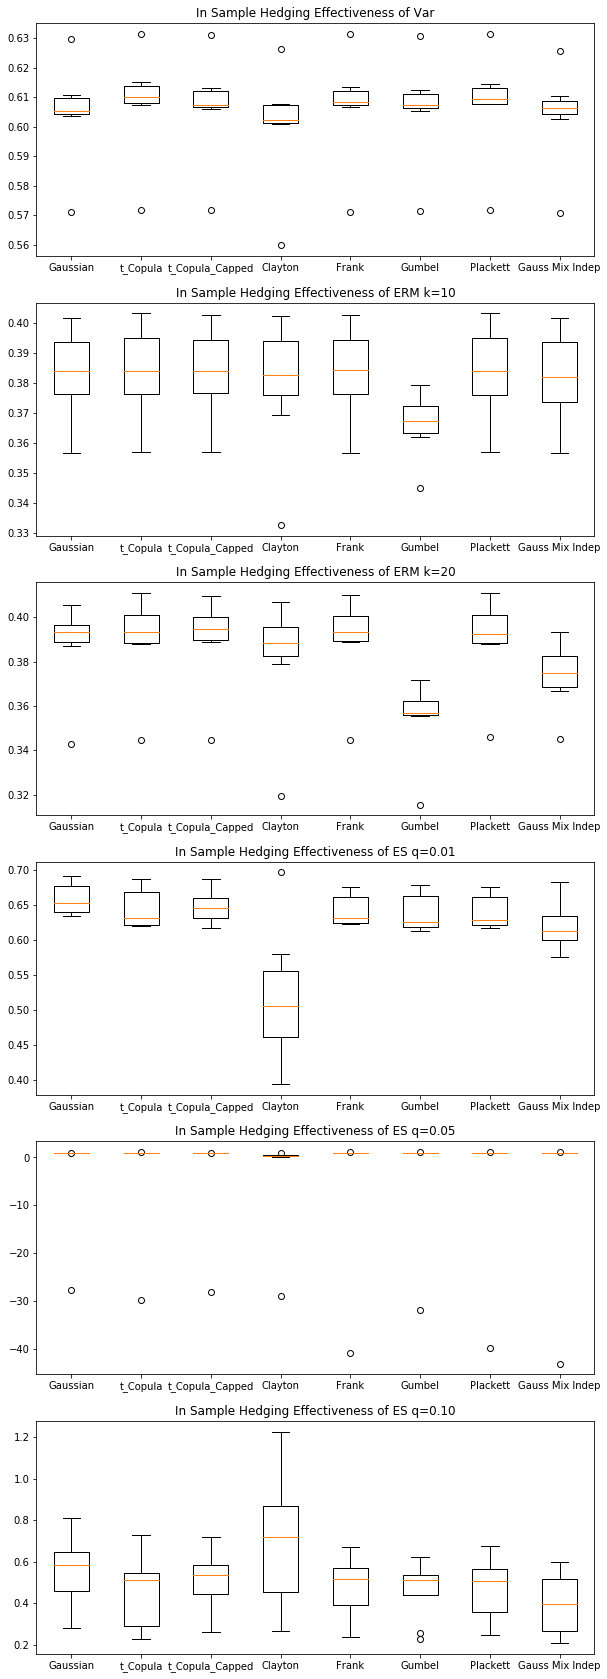

In [16]:
HE_results = []

for i, file in enumerate(ls):
    test = pd.read_csv(data_path+'train/'+file)
    spot   = test.loc[:,spot_name]
    future = test.loc[:,future_name]
    fn = lambda h_arr: hedging_effectiveness(h_arr, spot, future, k_arr, q_arr)
    HE = pd.DataFrame().reindex_like(best_h_results[0])
    HEs = best_h_results[i].apply(fn, axis=1)
    for i in range(len(HEs)):
        HE.iloc[i,:] = HEs[i]
    HE_results.append(HE)
HE_results_pd = pd.concat(dict(zip(ls, HE_results)), axis=1)
risk_measure_names = HE_results_pd.droplevel(0,axis=1).columns.unique()

fig, ax = plt.subplots(len(risk_measure_names), 1, figsize=(10,5*len(risk_measure_names)))
for i, name in enumerate(risk_measure_names): 
    ax[i].boxplot(HE_results_pd.droplevel(0,axis=1).loc[:,name])
    ax[i].set_xticklabels(Copulae_names)
    ax[i].set_title("In Sample Hedging Effectiveness of %s"%name)
    
if calibration_method == "MLE":
    fig.savefig("../results/"+ data_name +"/MLE/"+"In Sample Hedging Effectiveness.png", transparent=True)    
elif calibration_method == "MM":
    fig.savefig("../results/"+ data_name +"/MM/"+"In Sample Hedging Effectiveness.png", transparent=True)

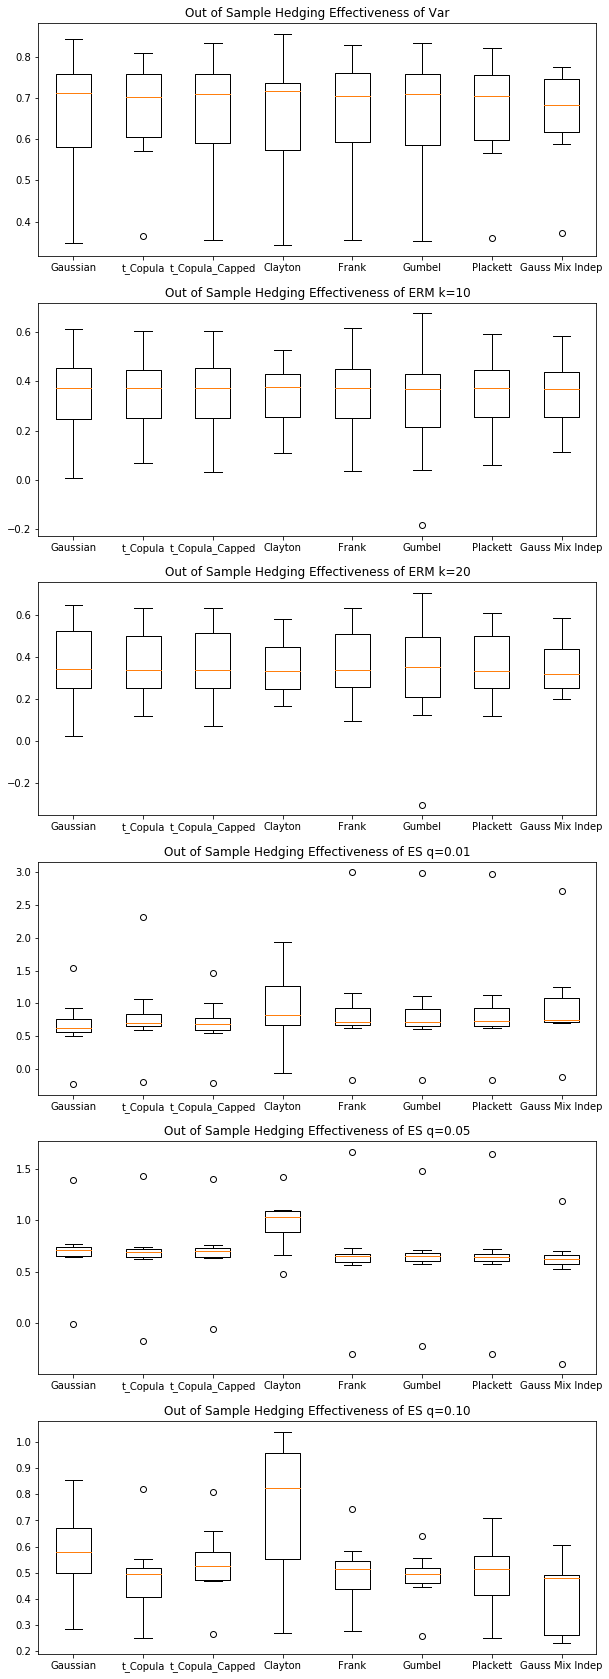

In [17]:
HE_results = []

for i, file in enumerate(ls):
    test = pd.read_csv(data_path+'test/'+file)
    spot   = test.loc[:,spot_name]
    future = test.loc[:,future_name]
    fn = lambda h_arr: hedging_effectiveness(h_arr, spot, future, k_arr, q_arr)
    HE = pd.DataFrame().reindex_like(best_h_results[0])
    HEs = best_h_results[i].apply(fn, axis=1)
    for i in range(len(HEs)):
        HE.iloc[i,:] = HEs[i]
    HE_results.append(HE)
HE_results_pd = pd.concat(dict(zip(ls, HE_results)), axis=1)
risk_measure_names = HE_results_pd.droplevel(0,axis=1).columns.unique()

fig, ax = plt.subplots(len(risk_measure_names), 1, figsize=(10,5*len(risk_measure_names)))
for i, name in enumerate(risk_measure_names): 
    ax[i].boxplot(HE_results_pd.droplevel(0,axis=1).loc[:,name])
#     ax[i].set_xticks(np.linspace(1,len(Copulae_names)))
    ax[i].set_xticklabels(Copulae_names)
    ax[i].set_title("Out of Sample Hedging Effectiveness of %s"%name)
if calibration_method == "MLE":
    fig.savefig("../results/"+ data_name +"/MLE/"+"Out of Sample Hedging Effectiveness.png", transparent=True)    
elif calibration_method == "MM":
    fig.savefig("../results/"+ data_name +"/MM/"+"Out of Sample Hedging Effectiveness.png", transparent=True)